# SSFM

In [57]:
%matplotlib widget
%reload_ext autoreload
%autoreload 2

import numpy as np
import scipy
import pandas as pd
import tdt
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import yaml
import re

import hypnogram as hp
from ecephys.utils import replace_outliers
import ecephys.plot as eplt
import ecephys.signal.timefrequency as tfr
import ecephys.signal.utils as kd
import ecephys.signal.kd_plotting as kp
import ecephys.signal.kd_pax as kpx
import ecephys.xrsig.hypnogram_utils as xrhyp
import tdt_xarray as tx

import adtk
from adtk.detector import GeneralizedESDTestAD
from adtk.visualization import plot

from sklearn.decomposition import PCA
from neurodsp.plts.utils import check_ax

bp_def = dict(delta=(0.5, 4), theta=(4, 8), sigma = (11, 16), beta = (13, 20), low_gamma = (40, 55), high_gamma = (65, 80), omega=(200, 600))

kd_ref = {}
kd_ref['echans'] = [1,2]
kd_ref['fchans']=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
kd_ref['analysis_root'] = Path('/Volumes/paxilline/Data/paxilline_project_materials/PAX_7/PAX_7_analysis_data')
kd_ref['tank_root'] = Path(r"N:\Data\PAX_7\PAX_7_TANK")
kd_ref['key_list'] = ['list of strings']

# Housekeeping

In [75]:
# Standard test dataset for SSFM:
data_path = '/Volumes/paxilline/Data/PAX_7/PAX_7_TANK/PAX_7-dmso-bl'
ssfm = {}
ssfm['e'], ssfm['espg'] = kd.get_data_spg(data_path, store='EEGr', t1=0, t2=7200, channel=kd_ref['echans'], window_length=10, overlap=1)
ssfm['m'], ssfm['mspg'] = kd.get_data_spg(data_path, store='EMGr', t1=0, t2=7200, channel=[1,2], window_length=10, overlap=1)
ssfm['e_pd'], ssfm['espg_pd'] = kd.get_data_spg(data_path, store='EEGr', t1=0, t2=7200, channel=kd_ref['echans'], window_length=10, overlap=1, pandas=True)
ssfm['m_pd'], ssfm['mspg_pd'] = kd.get_data_spg(data_path, store='EMGr', t1=0, t2=7200, channel=[1,2], window_length=10, overlap=1, pandas=True)
ssfm['ebp_pd'] = kd.get_bp_set2(ssfm['espg'], bands=bp_def, pandas=True)
ssfm['ebp'] = kd.get_bp_set2(ssfm['espg'], bands=bp_def, pandas=False)

muscle_bands = dict(delta=(0,4), omega=(1, 800))
ssfm['mbp_pd'] = kd.get_bp_set2(ssfm['mspg'], bands=muscle_bands, pandas=True)


hyp_yaml = "N:\Data\paxilline_project_materials\pax-hypno-paths.yaml"
subject = "PAX_7"
exp = "exp-2"
p_2h = "/Volumes/paxilline/Data//paxilline_project_materials/PAX_7/hypnograms-PAX_7/hypno_dmso_BL1.txt"
ssfm['hyp_full'] = kd.load_hypnograms(subject, exp, "dmso-bl", ssfm['espg'].datetime.values.min())
ssfm['hyp_2hr'] = load_ssfm_hypnogram(p_2h, ssfm['espg'].datetime.values.min())

# Not using LFP for now...
# ssfm['f'], ssfm['fspg'] = kd.get_data_spg(data_path, store='LFP_', t1=0, t2=7200, channel=kd_ref['fchans'], dt_dim=True)

read from t=0s to t=7502.02s
Using 1525.8789 Hz as SEV sampling rate for EEGr
Remember to save all data in xset-style dictionary, and to add experiment name key (key = "name") before using save_xset
read from t=0s to t=7502.02s
Remember to save all data in xset-style dictionary, and to add experiment name key (key = "name") before using save_xset
read from t=0s to t=7502.02s
Using 1525.8789 Hz as SEV sampling rate for EEGr
Remember to save all data in xset-style dictionary, and to add experiment name key (key = "name") before using save_xset
read from t=0s to t=7502.02s
Remember to save all data in xset-style dictionary, and to add experiment name key (key = "name") before using save_xset


In [95]:
# SSFM FUNCTIONS - DO not modify!!

def shade_hypno_for_me(
    hypnogram, ax=None, xlim=None
):
    """Shade plot background using hypnogram state.

    Parameters
    ----------
    hypnogram: pandas.DataFrame
        Hypnogram with with state, start_time, end_time columns.
    ax: matplotlib.Axes, optional
        An axes upon which to plot.
    """
    hypno_colors = {
    "Wake": "forestgreen",
    "Brief-Arousal": "chartreuse",
    "Transition-to-NREM": "lightskyblue",
    "Transition-to-Wake": "palegreen",
    "NREM": "royalblue",
    "Transition-to-REM": "plum",
    "REM": "magenta",
    "Transition": "grey",
    "Art": "crimson",
    "Wake-art": "crimson",
    "Unsure": "white",
    }
    xlim = ax.get_xlim() if (ax and not xlim) else xlim

    ax = check_ax(ax)
    for bout in hypnogram.itertuples():
        ax.axvspan(
            bout.start_time,
            bout.end_time,
            alpha=0.3,
            color=hypno_colors[bout.state],
            zorder=1000,
            ec="none",
        )

    ax.set_xlim(xlim)
    return ax


def build_hypno_for_me(states_and_times):
    """ states_and_times --> series with only the timepoints corresponding sleep states (i.e. data that has already been 'scored')"""
    
    # Get boolean series for each state
    nrem_bool = states_and_times == 'NREM'
    wake_bool = states_and_times == 'Wake'
    rem_bool = states_and_times == 'REM'

    # Use the boolean series to get start and end times for each state
    nrem_sne = starts_and_ends(nrem_bool)
    wake_sne = starts_and_ends(wake_bool)
    rem_sne = starts_and_ends(rem_bool)

    # Then we convert the start and end times for each state to a partial hypnogram
    nrem_hyp = pd.DataFrame(columns = ['state', 'end_time', 'start_time', 'duration'])
    nrem_hyp[['start_time', 'end_time']] = nrem_sne
    nrem_hyp['duration'] = nrem_hyp.end_time - nrem_hyp.start_time
    nrem_hyp['state'] = 'NREM'

    wake_hyp = pd.DataFrame(columns = ['state', 'end_time', 'start_time', 'duration'])
    wake_hyp[['start_time', 'end_time']] = wake_sne
    wake_hyp['duration'] = wake_hyp.end_time - wake_hyp.start_time
    wake_hyp['state'] = 'Wake'

    rem_hyp = pd.DataFrame(columns = ['state', 'end_time', 'start_time', 'duration'])
    rem_hyp[['start_time', 'end_time']] = rem_sne
    rem_hyp['duration'] = rem_hyp.end_time - rem_hyp.start_time
    rem_hyp['state'] = 'REM'

    #Then we concat those and sort by the start_time 
    fin_hypno = pd.concat([nrem_hyp, wake_hyp, rem_hyp])
    fin_hypno = fin_hypno.sort_values('start_time')
       
    return fin_hypno

def starts_and_ends(s, minimum_duration=np.timedelta64(3, 's')):
    start_times = np.empty(0)
    end_times = np.empty(0)
    period = s.index[1] - s.index[0]

    s_trues = s[s==True]
    ix = s_trues.index
    ix_counter = np.arange(0, len(ix))

    try:
        for i in ix_counter:
            if (ix[i] - period) != ix[i-1]:
                start_times = np.append(start_times, ix[i])
            if (ix[i] + period) != ix[i+1]:
                end_times = np.append(end_times, (ix[i] + period))
            elif np.logical_and((ix[i] + period) == ix[i+1], (ix[i] - period) == ix[i-1]):
                pass 
    except IndexError:
        print('passing indexing error (starts_and_ends)')
        pass
    end_times = np.append(end_times, (ix[ix_counter.max()] + period))
    return [(start_time, end_time)
            for start_time, end_time in zip(start_times, end_times)
            if end_time >= (start_time + minimum_duration)]


def threshplot(data, time=None, percentiles=[50, 60, 65, 70]):
    
    %matplotlib inline
    # Plot the threshold options for scoring out the NREM: 
    f, h_ax = plt.subplots(figsize=(40, 15))
    h_ax = sns.histplot(data=data, bins=20, ax=h_ax)
    h_ax.axvline(np.percentile(data, percentiles[0]), color='magenta')
    h_ax.axvline(np.percentile(data, percentiles[1]), color='b')
    h_ax.axvline(np.percentile(data, percentiles[2]), color='forestgreen')
    h_ax.axvline(np.percentile(data, percentiles[3]), color='r')
    plt.show()
    
    f, lin_ax = plt.subplots(figsize=(40, 15))
    lin_ax = sns.lineplot(x=time, y=data, ax=lin_ax)
    lin_ax.axhline(np.percentile(data, percentiles[0]), color='magenta')
    lin_ax.axhline(np.percentile(data, percentiles[1]), color='b')
    lin_ax.axhline(np.percentile(data, percentiles[2]), color='forestgreen')
    lin_ax.axhline(np.percentile(data, percentiles[3]), color='r')
    plt.show()
    return h_ax, lin_ax


def ssfm_v1(spg, emg_spg, nrem_percentiles=[50, 60, 65, 70], rem_percentiles=[60, 70, 80, 85], chan=2, f_range=slice(0, 100)):
    """Uses the metrics and scoring techniques of Watson et al., 2016 (Neuron)
    
    spg --> xarray spectrogram containing the channel you wish to use for scoring
    emg_spg --> spectrogram of emg, channel 1 is always selected out by default
    chan --> the channel you want to use
    f_range --> the range of frequencies to use for the PCA"""

    # First we get the EMG Band: 
    muscle_bands = dict(omega=(300, 700))
    emg_bands = kd.get_bp_set2(emg_spg, bands=muscle_bands, pandas=True)
    emg = emg_bands.xs(1, level='channel').omega
    
    # Then we get one channel in a given frequency range, and do the PCA
    spg_np = spg.sel(channel=chan, frequency=f_range).to_numpy().T
    pca = PCA(n_components=1)
    pca.fit(spg_np)
    pc = pca.transform(spg_np).flatten()

    # Then Theta Band: 
    theta_narrow = (5, 10)
    theta_wide = (2, 16) 
    thetaband = kd.get_bandpower(spg.sel(channel=chan), f_range=theta_narrow)/kd.get_bandpower(spg.sel(channel=chan), f_range=theta_wide)
    thetaband = (thetaband/emg)/emg

    # Now we can construct the Dataframe which will be used to assign states
    dt_ix = spg.datetime.values
    scoring_df = pd.Series(pc, index=dt_ix)
    scoring_df = scoring_df.to_frame(name='PC1')
    scoring_df['Theta'] = thetaband.values
    scoring_df['EMG'] = emg.values
    scoring_df['state'] = np.nan 
    
    # Now we need to figure out and set the thresholds for scoring out the NREM:
    hist, pcax = threshplot(pc, time=spg.datetime.values, percentiles=nrem_percentiles)
    
    nrem_threshold = float(input("Enter NREM Threshold: "))
    nrem_threshold = np.percentile(pc, nrem_threshold)

    #This is where we actually "score" the NREM based on a simple threshold value
    scoring_df.loc[scoring_df.PC1 >= nrem_threshold, 'state'] = 'NREM'
    
    # Now we need to set the threshold for REM::
    hist_rem, theta = threshplot(data=thetaband.values, time=spg.datetime.values, percentiles=rem_percentiles)

    rem_threshold = float(input("Enter REM Threshold: "))
    rem_threshold = np.percentile(thetaband.values, rem_threshold)

    #This is where we actually "score" the REM based on a simple threshold value
    scoring_df.loc[np.logical_and(scoring_df.Theta>=rem_threshold, scoring_df.state != 'NREM'), 'state'] = 'REM'
    
    #Now we just score the rest of the hypnogram as Wake:
    scoring_df.loc[np.logical_and(scoring_df.state!="NREM", scoring_df.state!='REM'), 'state'] = 'Wake'

    "At this point, all of the data is actually scored, and we can simply call build_hypno_for_me to get the start and end times and build the hypnogram"
    
    final_hypno = build_hypno_for_me(scoring_df['state'])
    m, d, g = plot_hypno_for_me(final_hypno, spg, emg_spg, bp_def)

    return final_hypno


def plot_hypno_for_me(hypno, spg, emg_spg, bp_def, chan=2, smooth=False):
    fig, (m, d, g) = plt.subplots(ncols=1, nrows=3, figsize=(35,15))
    emg_spg = emg_spg.sel(channel=1)
    spg = spg.sel(channel=chan)
    
    #plot muscle activity
    emg_bp = kd.get_bandpower(emg_spg, bp_def['omega'])
    if smooth==True:
        emg_bp = kd.get_smoothed_da(emg_bp, smoothing_sigma=12)
    sns.lineplot(x=spg.datetime, y=emg_bp, color='black', ax=m) 
    shade_hypno_for_me(hypnogram=hypno, ax=m)
    m.set_title('Muscle Activity (Full Spectrum)')

    #plot delta power
    delta = kd.get_bandpower(spg, bp_def['delta'])
    if smooth==True:
        delta = kd.get_smoothed_da(delta, smoothing_sigma=12)
    sns.lineplot(x=delta.datetime, y=delta, color='black', ax=d)
    shade_hypno_for_me(hypnogram=hypno, ax=d)
    d.set_title('EEG-'+str(chan)+' Delta Bandpower')

    #plot gamma power
    gamma = kd.get_bandpower(spg, bp_def['high_gamma'])
    if smooth==True:
        gamma = kd.get_smoothed_da(gamma, smoothing_sigma=12)
    sns.lineplot(x=spg.datetime, y=gamma, color='black', ax=g)
    shade_hypno_for_me(hypnogram=hypno, ax=g)
    g.set_title('EEG-'+str(chan)+' Gamma Bandpower')

    return m, d, g

# Watson Method (SSFM_v1)

From Watson et. al 2016 (Neuron):

"Three signals were used to score state in our recordings: broadband LFP, narrowband theta frequency LFP, and EMG. Broadband LFP was extracted from a cortical probe and principal components analysis (PCA) was applied to the z-transformed (1-100Hz) spectrogram."

## Get PCA of EEG-2

Currently, the 'pc' variable is the best output of this function. But I have a feeling that will either need to be smoothed, or the spectrogram calculation window made longer. 

In [302]:
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

In [303]:
ssfm['hyp_2hr']

,state,end_time,start_time,duration
0,Art,2021-11-03 09:03:25.389740784,2021-11-03 09:03:16.999740441,0 days 00:00:08.390000343
1,Wake,2021-11-03 09:03:43.489740212,2021-11-03 09:03:25.389740784,0 days 00:00:18.099999428
2,Art,2021-11-03 09:04:20.389739831,2021-11-03 09:03:43.489740212,0 days 00:00:36.899999619
3,Wake,2021-11-03 09:04:33.289741357,2021-11-03 09:04:20.389739831,0 days 00:00:12.900001526
4,Art,2021-11-03 09:05:07.789741357,2021-11-03 09:04:33.289741357,0 days 00:00:34.500000
...,...,...,...,...
260,Wake,2021-11-03 11:02:11.989974816,2021-11-03 11:01:49.089584191,0 days 00:00:22.900390625
261,Unsure,2021-11-03 11:02:13.789779503,2021-11-03 11:02:11.989974816,0 days 00:00:01.799804688
262,Wake,2021-11-03 11:02:25.989974816,2021-11-03 11:02:13.789779503,0 days 00:00:12.200195312
263,Art,2021-11-03 11:02:54.089584191,2021-11-03 11:02:25.989974816,0 days 00:00:28.099609375


In [304]:
# This gets us a spectrogram of EEG-2 from 0-100Hz, with the right shape for the PCA:
spg_pca = ssfm['espg'].sel(channel=2, frequency=slice(0,100.1)).to_numpy().T

In [305]:
ssfm['espg'].datetime.values

array(['2021-11-03T09:03:16.999740441', '2021-11-03T09:03:25.999799322',
       '2021-11-03T09:03:34.999858204', '2021-11-03T09:03:43.999917085',
       '2021-11-03T09:03:52.999975967', '2021-11-03T09:04:02.000034848',
       '2021-11-03T09:04:11.000093730', '2021-11-03T09:04:20.000152611',
       '2021-11-03T09:04:29.000211493', '2021-11-03T09:04:38.000270374',
       '2021-11-03T09:04:47.000329256', '2021-11-03T09:04:56.000388137',
       '2021-11-03T09:05:05.000447019', '2021-11-03T09:05:14.000505900',
       '2021-11-03T09:05:23.000564781', '2021-11-03T09:05:32.000623663',
       '2021-11-03T09:05:41.000682544', '2021-11-03T09:05:50.000741426',
       '2021-11-03T09:05:59.000800307', '2021-11-03T09:06:08.000859189',
       '2021-11-03T09:06:17.000918070', '2021-11-03T09:06:26.000976952',
       '2021-11-03T09:06:35.001035833', '2021-11-03T09:06:44.001094715',
       '2021-11-03T09:06:53.001153596', '2021-11-03T09:07:02.001212478',
       '2021-11-03T09:07:11.001271359', '2021-11-03

In [306]:
#Gets us a scaled version of that spectrogram
scaler = StandardScaler()
scaler.fit(spg_pca)
scaled_spg_pca = scaler.transform(spg_pca)

In [307]:
# This does the PCA of our raw, unscaled spectrogram
pca_100 = PCA(n_components=1)
pca_100.fit(spg_pca)
pc = pca_100.transform(spg_pca).flatten()

In [308]:
# This does the PCA of our scaled spectrogram
pca_100_scaled = PCA(n_components=1)
pca_100_scaled.fit(scaled_spg_pca)
pc_scaled = pca_100_scaled.transform(scaled_spg_pca).flatten()

In [408]:
np.percentile(pc, 60)


207.5842285156249

In [311]:
f, ax = plt.subplots()
ax = sns.lineplot(x=ssfm['espg'].datetime.values, y=pc_scaled, ax=ax)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [359]:
# With EMG factoring:
pc_over_emg = pc/emg
f, ax = plt.subplots()
ax = sns.lineplot(x=ssfm['espg'].datetime.values, y=pc_over_emg, ax=ax)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [311]:
f, ax = plt.subplots()
ax = sns.lineplot(x=ssfm['espg'].datetime.values, y=pc_scaled, ax=ax)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [325]:
f, ax = plt.subplots()
ax = sns.histplot(data=pc)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Get the theta metric

"Theta was taken to be the ratio 5-10Hz/2-16Hz from the spectrogramto help differentiate from states of high theta power in cortex simply due to nonREM status."

In [314]:
theta_narrow = (5, 10)
theta_wide = (2, 16) 
thetaband = kd.get_bandpower(ssfm['espg'].sel(channel=2), f_range=theta_narrow)/kd.get_bandpower(ssfm['espg'].sel(channel=2), f_range=theta_wide)

In [348]:
tbe = thetaband/emg

In [360]:
tbe = tbe/emg

In [361]:
f, ax = plt.subplots()
ax = sns.lineplot(x=ssfm['espg'].datetime.values, y=tbe, ax=ax)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Get EMG

Could use the raw muscle signal:

In [315]:
ssfm['m'].sel(channel=1)

<xarray.DataArray 'EMGr' (datetime: 10986328)>
array([-140.47998 ,  132.864   ,   60.479996, ...,  275.90396 ,
        -64.76799 ,  126.847984], dtype=float32)
Coordinates:
    time       (datetime) float64 0.0 0.0006554 0.001311 ... 7.2e+03 7.2e+03
    channel    int64 1
    timedelta  (datetime) timedelta64[ns] 00:00:00 ... 01:59:59.999262720
  * datetime   (datetime) datetime64[ns] 2021-11-03T09:03:11.999999 ... 2021-...
Attributes:
    units:    uV
    fs:       1525.87890625

Or, could use the muscle spectrogram:

In [316]:
ssfm['mspg'].sel(channel=1)

<xarray.DataArray (frequency: 7630, datetime: 799)>
array([[1.27300159e+03, 5.74169769e+01, 3.44270205e+00, ...,
        5.04780794e-03, 2.66581688e+01, 4.96126741e-01],
       [4.25545850e+03, 9.67645508e+02, 1.72843124e+02, ...,
        6.78325500e+01, 1.66617505e+03, 5.01291885e+01],
       [2.91740649e+03, 8.72482422e+02, 2.86352881e+03, ...,
        5.02189178e+02, 2.53187646e+03, 2.65141010e-01],
       ...,
       [3.09694576e+01, 1.49222631e+01, 1.02537415e+02, ...,
        7.61703186e+01, 5.03641205e+01, 8.88217151e-01],
       [1.04592867e+01, 6.22327375e+00, 2.15702377e+02, ...,
        1.39575989e+02, 1.12287836e+01, 6.29380703e-01],
       [8.20618123e-02, 8.37552738e+00, 1.12415688e+02, ...,
        7.00636749e+01, 1.42798483e-01, 6.62462115e-01]], dtype=float32)
Coordinates:
  * frequency  (frequency) float64 0.0 0.1 0.2 0.3 ... 762.6 762.7 762.8 762.9
    time       (datetime) float64 5.0 14.0 23.0 ... 7.178e+03 7.187e+03
    channel    int64 1
    timedelta  (datetime) timedelta64[ns] 00:00:04.999741440 ... 01:59:47.046...
  * datetime   (datetime) datetime64[ns] 2021-11-03T09:03:16.999740440 ... 20...
Attributes:
    units:    uV^2/Hz

Or, could use the 'omega' all-encompassing EMG-bandpower (1-800Hz)

In [317]:
emg = ssfm['mbp_pd'].xs(1, level='channel').omega

## Build the Watson-style scorer 

"First NREM time points were extracted via a threshold atthe trough between the peaks in the broadband PC1 histogram. Among the remaining time points, REM was recognizedby finding timepoints with bothEMG values below the bimodal dip in that metric and thetain the upper mode of the distribution. States not classified as REM or nonREM were classified as arousals.  Microarousals were arousals <40s duration and occurring between nonREM packets (see Figure S1D).  Full WAKE was defined as 7min or longer arousals as this time cutoff was found to more reliably correlate with animal active behavior. SLEEP was defined as a combination of nonREM, REM or MA spanning at least 20 minutes and with no individual interruption greater than 2 minutes. To account for noise, states of duration <2s were joined with the adjacent state."

In [362]:
# First construct dataframe with the 3 metrics:
dt_ix = ssfm['espg'].datetime.values
wtsn = pd.Series(pc, index=dt_ix)
wtsn = wtsn.to_frame(name='PC1')
wtsn['Theta'] = tbe.values
wtsn['EMG'] = emg.values
wtsn['state'] = np.nan

In [370]:
# Define Cutoffs and "score" the data
pc1_cut = 500
tb_cut = 2.5e-09
wtsn.loc[wtsn.PC1 >= pc1_cut, 'state'] = 'NREM'
wtsn.loc[np.logical_and(wtsn.Theta>=tb_cut, wtsn.state != 'NREM'), 'state'] = 'REM'
wtsn.loc[np.logical_and(wtsn.state!="NREM", wtsn.state!='REM'), 'state'] = 'Wake'

In [374]:
# Use the scoring to build hypno and plot:
states = wtsn['state']
ax, h = hypno_builder(states)

passing indexing error
passing indexing error
passing indexing error


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [380]:
# And compare to my scoring: 
nh = ssfm['hyp_2hr']
nh.loc[nh.state=='Art', 'state'] = 'Wake'
ax = plot_hypnogram_overlay(nh)

In [385]:
nh

,state,end_time,start_time,duration
0,Wake,2021-11-03 09:03:25.389740784,2021-11-03 09:03:16.999740441,0 days 00:00:08.390000343
1,Wake,2021-11-03 09:03:43.489740212,2021-11-03 09:03:25.389740784,0 days 00:00:18.099999428
2,Wake,2021-11-03 09:04:20.389739831,2021-11-03 09:03:43.489740212,0 days 00:00:36.899999619
3,Wake,2021-11-03 09:04:33.289741357,2021-11-03 09:04:20.389739831,0 days 00:00:12.900001526
4,Wake,2021-11-03 09:05:07.789741357,2021-11-03 09:04:33.289741357,0 days 00:00:34.500000
...,...,...,...,...
260,Wake,2021-11-03 11:02:11.989974816,2021-11-03 11:01:49.089584191,0 days 00:00:22.900390625
261,Unsure,2021-11-03 11:02:13.789779503,2021-11-03 11:02:11.989974816,0 days 00:00:01.799804688
262,Wake,2021-11-03 11:02:25.989974816,2021-11-03 11:02:13.789779503,0 days 00:00:12.200195312
263,Wake,2021-11-03 11:02:54.089584191,2021-11-03 11:02:25.989974816,0 days 00:00:28.099609375


# Comparitor

In [76]:
hkd = ssfm['hyp_2hr']

In [91]:
hkd.loc[hkd.state=='Art', 'state'] = 'Wake'


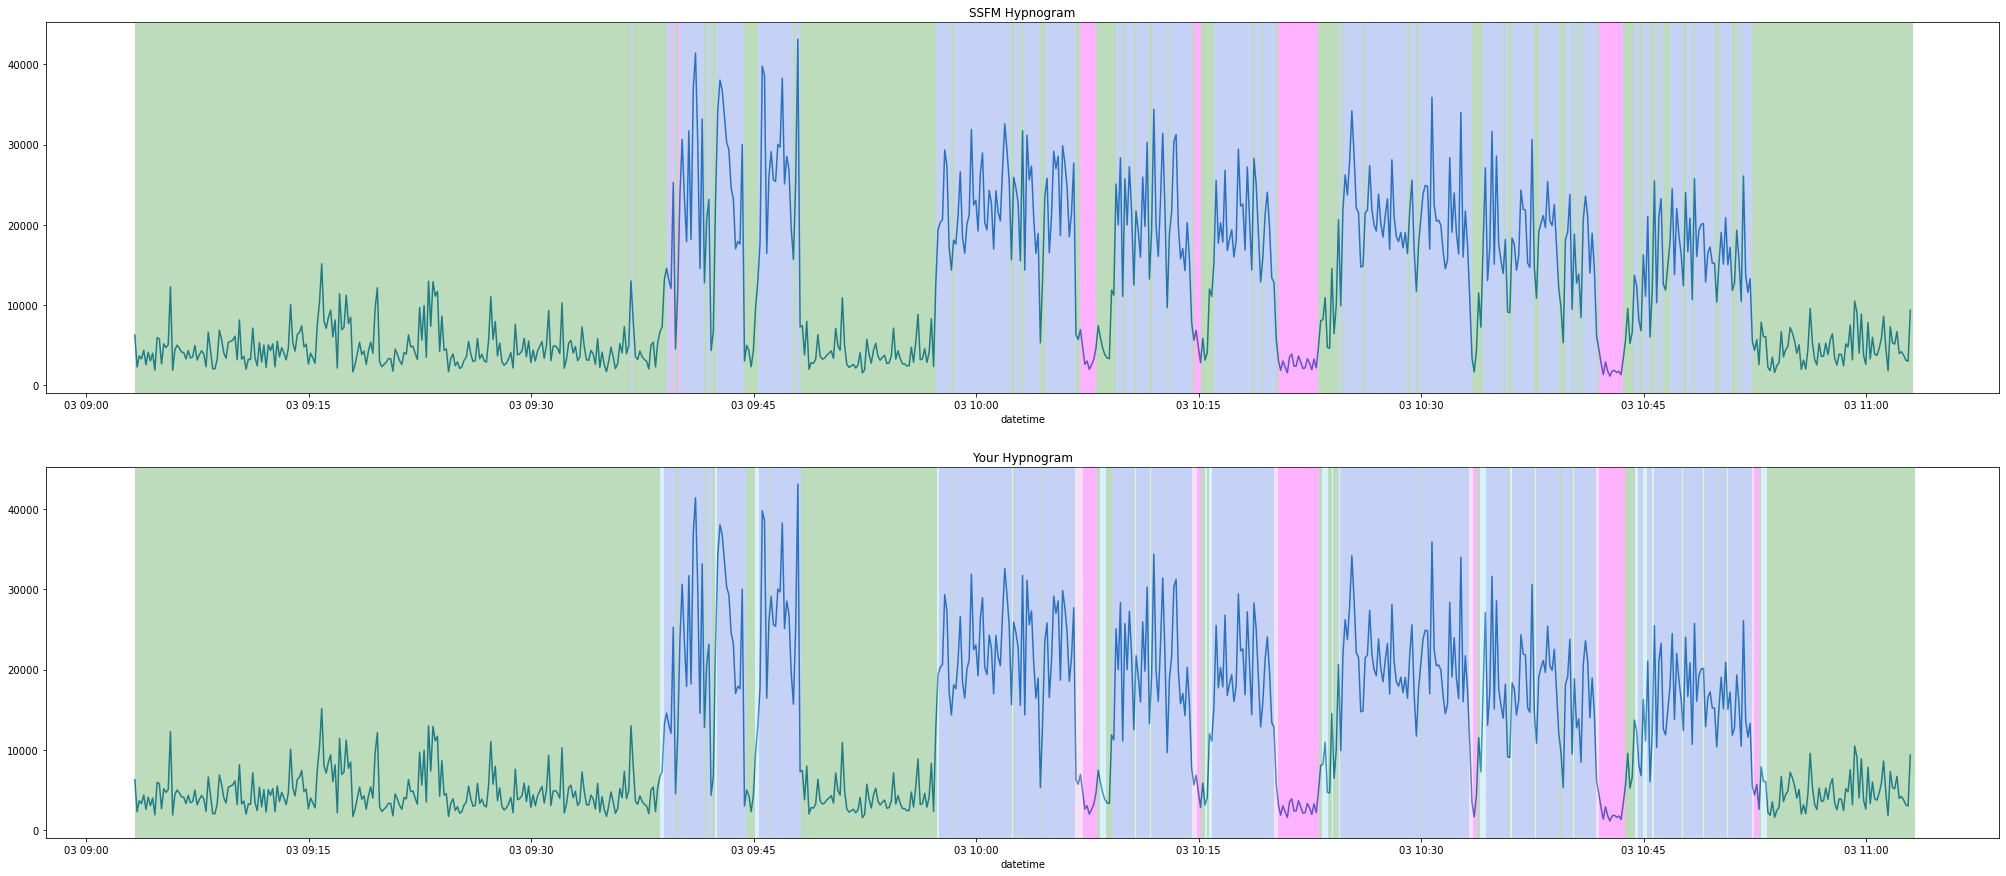

In [102]:
a1, a2 = compare_hypnos_for_me(ssfm['espg'], h, hkd)